In [ ]:
import time
import threading
import uuid
import random
import psutil
import math
from concurrent.futures import ThreadPoolExecutor
from queue import Queue
import collections

# 儲存執行緒狀態的字典 (模擬 SQLite/Redis)
thread_status = {}

# 任務隊列 (模擬 Job Queue)
job_queue = Queue()

# 任務到達歷史 - 用於Little's Law計算
job_arrival_history = collections.deque(maxlen=100)  # 最多存儲100個數據點

# 上次任務生成時間
last_job_generation_time = time.time()

# 全局變數追蹤系統數據
total_jobs_in_hour = 0
hour_start_time = time.time()
current_optimal_threads = 8  # 初始值

# 基於Little's Law計算最佳執行緒數
def calculate_optimal_thread_count():
    global current_optimal_threads
    current_time = time.time()

    # 檢查是否有足夠的數據進行計算
    if len(job_arrival_history) < 2:
        return current_optimal_threads

    # 計算到達率 (每秒到達的任務數)
    # 使用最近20分鐘的數據或所有可用數據
    timespan = min(1200, current_time - job_arrival_history[0][0])
    if timespan <= 0:
        return current_optimal_threads

    arrival_count = len(job_arrival_history)
    arrival_rate = arrival_count / timespan  # 每秒到達的任務數

    # 服務時間固定為20秒
    service_time = 20

    # 應用Little's Law: L = λW
    # 其中L是系統中的任務數量，λ是到達率，W是服務時間
    optimal_threads = math.ceil(arrival_rate * service_time)

    # 獲取CPU核心數
    cpu_cores = psutil.cpu_count(logical=True)

    # 根據系統性能設定合理範圍
    min_threads = max(3, cpu_cores // 2)  # 最少為CPU核心數的一半或3
    max_threads = max(16, cpu_cores * 2)  # 最多為CPU核心數的2倍或16

    # 確保執行緒數在合理範圍內
    optimal_threads = max(min_threads, min(max_threads, optimal_threads))

    # 平滑變化，避免大幅波動
    current_optimal_threads = int(0.7 * current_optimal_threads + 0.3 * optimal_threads)

    print(f"[{time.strftime('%H:%M:%S')}] Little's Law計算: 到達率={arrival_rate:.4f}/秒, "
          f"服務時間={service_time}秒, 理論最佳執行緒數={optimal_threads}, "
          f"平滑後執行緒數={current_optimal_threads}")

    return current_optimal_threads

# 監控 CPU 負載並結合Little's Law動態調整執行緒數量
def get_dynamic_worker_count():
    # 先獲取基於Little's Law的執行緒數
    optimal_threads = calculate_optimal_thread_count()

    # 然後根據CPU使用率進行調整
    cpu_usage = psutil.cpu_percent(interval=0.5)

    # 計算當前佇列的負載情況
    pending_count = sum(1 for v in thread_status.values() if v["state"] == "PENDING")
    queue_size = job_queue.qsize()
    total_pending = pending_count + queue_size

    # 根據CPU使用率和佇列情況進行綜合調整
    if cpu_usage > 85 or total_pending < 3:
        # 高CPU負載或幾乎沒有等待任務時，減少執行緒
        worker_count = max(3, int(optimal_threads * 0.6))
    elif cpu_usage < 40 and total_pending > 10:
        # 低CPU負載且有大量等待任務時，增加執行緒
        worker_count = min(20, int(optimal_threads * 1.4))
    else:
        # 一般情況下使用Little's Law計算的結果
        worker_count = optimal_threads

    print(f"[{time.strftime('%H:%M:%S')}] 執行緒池調整: "
          f"CPU={cpu_usage:.1f}%, 等待任務={total_pending}, "
          f"執行緒數={worker_count}")

    return worker_count

# 檢查未完成的任務並重新排程
def check_incomplete_jobs():
    current_time = time.time()
    rescheduled_count = 0
    global job_queue

    for job_id, status in list(thread_status.items()):
        if status["state"] == "PENDING":
            # 計算等待時間
            wait_time = current_time - status["queue_time"]

            # 如果等待超過5分鐘，提高優先級重新排程
            if wait_time > 300:
                # 從現有隊列中移除(如果存在)
                try:
                    job_queue.queue.remove(job_id)
                except:
                    pass  # 如果不在隊列中，忽略錯誤

                # 放回隊列前端
                temp_queue = Queue()
                temp_queue.put(job_id)

                # 將原隊列內容複製到新隊列
                while not job_queue.empty():
                    temp_queue.put(job_queue.get())

                # 替換隊列

                job_queue = temp_queue

                print(f"[{time.strftime('%H:%M:%S')}] 重新排程長時間等待的執行緒 {job_id} (等待時間: {wait_time:.2f}秒)")
                rescheduled_count += 1

        elif status["state"] == "RUNNING":
            # 檢查是否執行時間過長(超過30秒)
            if "start_time" in status:
                run_time = current_time - status["start_time"]
                if run_time > 30:  # 正常應該20秒完成
                    print(f"[{time.strftime('%H:%M:%S')}] 警告: 執行緒 {job_id} 執行時間過長 ({run_time:.2f}秒)")

    if rescheduled_count > 0:
        print(f"[{time.strftime('%H:%M:%S')}] 總共重新排程了 {rescheduled_count} 個長時間等待的執行緒")

# 產生執行緒 (每 5 分鐘觸發)
def add_jobs():
    global last_job_generation_time, total_jobs_in_hour, hour_start_time, job_queue

    while True:
        current_time = time.time()

        # 檢查是否進入新的小時
        if current_time - hour_start_time > 3600:
            total_jobs_in_hour = 0
            hour_start_time = current_time
            print(f"[{time.strftime('%H:%M:%S')}] 新的小時開始，重置任務計數")

        # 檢查未完成的任務
        check_incomplete_jobs()

        # 計算當前系統狀態
        optimal_threads = calculate_optimal_thread_count()
        pending_count = sum(1 for v in thread_status.values() if v["state"] == "PENDING")
        queue_size = job_queue.qsize()
        running_count = sum(1 for v in thread_status.values() if v["state"] == "RUNNING")

        # 計算系統負載因子
        system_capacity = optimal_threads * 20  # 每個執行緒處理20秒
        current_load = (running_count * 20) + (pending_count + queue_size) * 20
        load_factor = current_load / (system_capacity + 0.1)  # 避免除以0

        # 剩餘可生成的任務數，確保小時總量接近200
        remaining_hour_time = 3600 - (current_time - hour_start_time)
        remaining_intervals = max(1, remaining_hour_time / 300)
        remaining_jobs = 200 - total_jobs_in_hour

        # 根據負載因子和剩餘數量計算本次應生成的任務數
        target_jobs_per_interval = remaining_jobs / remaining_intervals

        # 根據負載調整生成數量
        if load_factor > 1.2:  # 負載很高
            num_jobs = random.randint(1, 5)
        elif load_factor > 0.8:  # 負載較高
            num_jobs = random.randint(3, 8)
        elif load_factor < 0.3:  # 負載很低
            num_jobs = random.randint(15, 20)
        elif load_factor < 0.6:  # 負載較低
            num_jobs = random.randint(10, 15)
        else:  # 負載適中
            num_jobs = random.randint(5, 15)

        # 考慮小時總量目標
        num_jobs = min(num_jobs, int(max(1, target_jobs_per_interval * 1.5)))
        num_jobs = max(1, min(20, num_jobs))  # 確保在1-20範圍內

        # 生成任務
        for _ in range(num_jobs):
            job_id = str(uuid.uuid4())
            job_queue.put(job_id)
            thread_status[job_id] = {
                "state": "PENDING",
                "queue_time": current_time,
                "creation_time": time.strftime('%H:%M:%S')
            }

            # 記錄任務到達
            job_arrival_history.append((current_time, job_id))

        total_jobs_in_hour += num_jobs

        print(f"[{time.strftime('%H:%M:%S')}] 加入 {num_jobs} 個執行緒到佇列 "
              f"(負載因子: {load_factor:.2f}, 本小時已生成: {total_jobs_in_hour})")

        # 更新最後生成時間
        last_job_generation_time = current_time

        # 等待5分鐘
        time.sleep(300)

# 執行緒處理函數
def process_thread(job_id):
    current_time = time.time()

    # 更新狀態為執行中
    if job_id in thread_status:
        thread_status[job_id]["state"] = "RUNNING"
        thread_status[job_id]["start_time"] = current_time
        thread_status[job_id]["start_time_str"] = time.strftime('%H:%M:%S')
    else:
        # 如果不在字典中，可能是新建的任務
        thread_status[job_id] = {
            "state": "RUNNING",
            "start_time": current_time,
            "start_time_str": time.strftime('%H:%M:%S'),
            "queue_time": current_time,
            "creation_time": time.strftime('%H:%M:%S')
        }

    print(f"[{time.strftime('%H:%M:%S')}] 執行執行緒 {job_id}")

    # 模擬執行 20 秒
    time.sleep(20)

    # 更新狀態為已完成
    thread_status[job_id]["state"] = "COMPLETED"
    thread_status[job_id]["completion_time"] = time.time()
    thread_status[job_id]["completion_time_str"] = time.strftime('%H:%M:%S')

    # 計算執行時間
    execution_time = thread_status[job_id]["completion_time"] - thread_status[job_id]["start_time"]
    thread_status[job_id]["execution_time"] = execution_time

    # 計算等待時間
    wait_time = thread_status[job_id]["start_time"] - thread_status[job_id]["queue_time"]
    thread_status[job_id]["wait_time"] = wait_time

    print(f"[{time.strftime('%H:%M:%S')}] 完成執行緒 {job_id} (執行時間: {execution_time:.2f}秒, 等待時間: {wait_time:.2f}秒)")

# 執行緒監控
def monitor_threads():
    while True:
        time.sleep(60)  # 每分鐘監控一次

        current_time = time.time()

        # 計算各狀態的任務數
        completed = sum(1 for v in thread_status.values() if v["state"] == "COMPLETED")
        pending = sum(1 for v in thread_status.values() if v["state"] == "PENDING")
        running = sum(1 for v in thread_status.values() if v["state"] == "RUNNING")

        # 計算平均等待和執行時間
        wait_times = [v.get("wait_time", 0) for v in thread_status.values() if v.get("wait_time") is not None]
        exec_times = [v.get("execution_time", 0) for v in thread_status.values() if v.get("execution_time") is not None]

        avg_wait = sum(wait_times) / len(wait_times) if wait_times else 0
        avg_exec = sum(exec_times) / len(exec_times) if exec_times else 0

        # 計算最大等待時間和當前最長等待
        max_wait = max(wait_times) if wait_times else 0

        # 計算當前等待中的任務最長等待時間
        current_waiting_times = []
        for job_id, status in thread_status.items():
            if status["state"] == "PENDING":
                current_waiting_times.append(current_time - status["queue_time"])

        current_max_wait = max(current_waiting_times) if current_waiting_times else 0

        print(f"[{time.strftime('%H:%M:%S')}] 監控報告: 執行中 {running} / 等待中 {pending} / 完成 {completed}")
        print(f"[{time.strftime('%H:%M:%S')}] 平均等待時間: {avg_wait:.2f}秒, 平均執行時間: {avg_exec:.2f}秒")
        print(f"[{time.strftime('%H:%M:%S')}] 歷史最大等待時間: {max_wait:.2f}秒, 當前最大等待: {current_max_wait:.2f}秒")
        print(f"[{time.strftime('%H:%M:%S')}] 佇列中任務數量: {job_queue.qsize()}")
        print(f"[{time.strftime('%H:%M:%S')}] 本小時已產生任務: {total_jobs_in_hour}/200")

# 詳細狀態報告
def detailed_status_report():
    while True:
        time.sleep(900)  # 每15分鐘產生一次詳細報告

        print("\n" + "="*50)
        print(f"[{time.strftime('%H:%M:%S')}] 詳細狀態報告")
        print("="*50)

        # 列出所有待處理任務
        pending_jobs = [(job_id, status) for job_id, status in thread_status.items() if status["state"] == "PENDING"]
        if pending_jobs:
            print("\n待處理任務:")
            for job_id, status in pending_jobs:
                wait_time = time.time() - status["queue_time"]
                print(f"  - {job_id[:8]}: 等待中 ({wait_time:.2f}秒), 創建於 {status.get('creation_time', 'N/A')}")

        # 列出所有執行中任務
        running_jobs = [(job_id, status) for job_id, status in thread_status.items() if status["state"] == "RUNNING"]
        if running_jobs:
            print("\n執行中任務:")
            for job_id, status in running_jobs:
                runtime = time.time() - status["start_time"]
                print(f"  - {job_id[:8]}: 執行中 ({runtime:.2f}秒), 開始於 {status.get('start_time_str', 'N/A')}")

        # 列出最近完成的10個任務
        completed_jobs = [(job_id, status) for job_id, status in thread_status.items() if status["state"] == "COMPLETED"]
        if completed_jobs:
            # 按完成時間排序，獲取最近10個
            recent_completed = sorted(
                completed_jobs,
                key=lambda x: x[1].get("completion_time", 0),
                reverse=True
            )[:10]

            print("\n最近完成的任務:")
            for job_id, status in recent_completed:
                print(f"  - {job_id[:8]}: 完成於 {status.get('completion_time_str', 'N/A')}, " +
                      f"執行時間: {status.get('execution_time', 0):.2f}秒, " +
                      f"等待時間: {status.get('wait_time', 0):.2f}秒")

        # 分析等待時間分布
        wait_times = [v.get("wait_time", 0) for v in thread_status.values() if v.get("wait_time") is not None]
        if wait_times:
            wait_times.sort()
            total = len(wait_times)

            print("\n等待時間分析:")
            print(f"  - 最小值: {min(wait_times):.2f}秒")
            print(f"  - 25%分位: {wait_times[total//4]:.2f}秒")
            print(f"  - 中位數: {wait_times[total//2]:.2f}秒")
            print(f"  - 75%分位: {wait_times[3*total//4]:.2f}秒")
            print(f"  - 最大值: {max(wait_times):.2f}秒")
            print(f"  - 平均值: {sum(wait_times)/total:.2f}秒")

        print("="*50 + "\n")

# 啟動執行緒池
def run_thread_pool():
    while True:
        # 獲取當前理想的執行緒池大小
        max_workers = get_dynamic_worker_count()

        # 創建執行緒池
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            pending_futures = []

            # 處理隊列中的任務直到為空
            while not job_queue.empty():
                # 獲取一個任務
                job_id = job_queue.get()

                # 檢查是否已經在執行中或已完成
                if job_id in thread_status:
                    if thread_status[job_id]["state"] in ["RUNNING", "COMPLETED"]:
                        continue

                # 提交任務到執行緒池
                future = executor.submit(process_thread, job_id)
                pending_futures.append(future)

                # 限制同時提交的任務數量，避免一次性提交太多
                if len(pending_futures) >= max_workers:
                    # 等待至少一個任務完成或短暫暫停
                    done, pending_futures = wait(pending_futures, return_when="FIRST_COMPLETED", timeout=0.5)

            # 等待所有已提交的任務完成
            for future in pending_futures:
                try:
                    future.result()
                except Exception as e:
                    print(f"[{time.strftime('%H:%M:%S')}] 執行緒執行錯誤: {e}")

        # 短暫暫停後再檢查佇列
        time.sleep(1)

# 等待函數，模擬concurrent.futures.wait
def wait(futures, return_when="ALL_COMPLETED", timeout=None):
    if return_when != "FIRST_COMPLETED":
        raise ValueError("僅支持FIRST_COMPLETED模式")

    start_time = time.time()
    done = []
    not_done = list(futures)

    while not_done:
        for i, future in enumerate(list(not_done)):
            if future.done():
                done.append(future)
                not_done.remove(future)
                return set(done), set(not_done)

        if timeout is not None and time.time() - start_time > timeout:
            break

        time.sleep(0.1)

    return set(done), set(not_done)

# 主函數
def main():
    # 啟動管理執行緒
    threading.Thread(target=add_jobs, daemon=True).start()
    threading.Thread(target=run_thread_pool, daemon=True).start()
    threading.Thread(target=monitor_threads, daemon=True).start()
    threading.Thread(target=detailed_status_report, daemon=True).start()

    print(f"[{time.strftime('%H:%M:%S')}] 系統已啟動")

    try:
        # 主執行緒保持活動以防止程式結束
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print(f"[{time.strftime('%H:%M:%S')}] 系統正在關閉...")

if __name__ == "__main__":
    main()

[12:16:03] 加入 16 個執行緒到佇列 (負載因子: 0.00, 本小時已生成: 16)[12:16:03] Little's Law計算: 到達率=11955.9708/秒, 服務時間=20秒, 理論最佳執行緒數=16, 平滑後執行緒數=10

[12:16:03] 系統已啟動
[12:16:03] 執行緒池調整: CPU=2.0%, 等待任務=32, 執行緒數=14
[12:16:03] 執行執行緒 8fcbebbc-3186-4b55-90bc-c71c104c6e02
[12:16:03] 執行執行緒 f6d605c7-5489-41b8-a6bb-4ac6cd66498d
[12:16:03] 執行執行緒 a91a7ed2-42a2-4698-aacd-70b435fc9f69
[12:16:03] 執行執行緒 6d53fca2-ddd5-49ff-8559-b100884c4d11
[12:16:03] 執行執行緒 2c820492-8ab1-4d21-8f6e-1ea9f415ac12
[12:16:03] 執行執行緒 642fae8f-ef7a-4280-95f6-68130ec6f4eb
[12:16:03] 執行執行緒 28284a48-f590-4d05-8b9d-484a62aa9ce9
[12:16:03] 執行執行緒 bea813e1-49c4-4807-89fb-b6440de51c0a
[12:16:03] 執行執行緒 9db420c8-da61-428d-a81e-2d8fe324fa42
[12:16:03] 執行執行緒 f4b6a22d-d4d6-459e-b18f-8e12970becb9
[12:16:03] 執行執行緒 22b6109e-a42d-463f-aaf9-9c23d7372c6b
[12:16:03] 執行執行緒 8bb93ecf-9a33-41da-abe8-cccfd5cad962
[12:16:03] 執行執行緒 d639d6d8-5fa0-4a3f-95db-effdd2e51871
[12:16:03] 執行執行緒 81432a68-f64f-49ec-909c-6cc77734726a
[12:16:23] 完成執行緒 8fcbebbc-3186-4b55-90bc-c71c104c6e0

Exception in thread Thread-14 (run_thread_pool):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-3-fbf51c835297>", line 375, in run_thread_pool
AttributeError: 'set' object has no attribute 'append'


[12:16:43] 完成執行緒 9a9e18ca-e2b6-427a-8698-dfc7c7e9c558 (執行時間: 20.00秒, 等待時間: 20.50秒)
[12:17:01] 監控報告: 執行中 0 / 等待中 1 / 完成 15
[12:17:01] 平均等待時間: 1.84秒, 平均執行時間: 20.00秒
[12:17:01] 歷史最大等待時間: 20.50秒, 當前最大等待: 58.04秒
[12:17:01] 佇列中任務數量: 1
[12:17:01] 本小時已產生任務: 16/200
[12:17:03] 監控報告: 執行中 0 / 等待中 1 / 完成 15
[12:17:03] 平均等待時間: 1.84秒, 平均執行時間: 20.00秒
[12:17:03] 歷史最大等待時間: 20.50秒, 當前最大等待: 60.00秒
[12:17:03] 佇列中任務數量: 1
[12:17:03] 本小時已產生任務: 16/200
[12:18:01] 監控報告: 執行中 0 / 等待中 1 / 完成 15
[12:18:01] 平均等待時間: 1.84秒, 平均執行時間: 20.00秒
[12:18:01] 歷史最大等待時間: 20.50秒, 當前最大等待: 118.04秒
[12:18:01] 佇列中任務數量: 1
[12:18:01] 本小時已產生任務: 16/200
[12:18:03] 監控報告: 執行中 0 / 等待中 1 / 完成 15
[12:18:03] 平均等待時間: 1.84秒, 平均執行時間: 20.00秒
[12:18:03] 歷史最大等待時間: 20.50秒, 當前最大等待: 120.00秒
[12:18:03] 佇列中任務數量: 1
[12:18:03] 本小時已產生任務: 16/200
[12:19:01] Little's Law計算: 到達率=0.0899/秒, 服務時間=20秒, 理論最佳執行緒數=3, 平滑後執行緒數=7
[12:19:01] 加入 16 個執行緒到佇列 (負載因子: 0.29, 本小時已生成: 32)
[12:19:01] 監控報告: 執行中 0 / 等待中 17 / 完成 15
[12:19:01] 平均等待時間: 1.84秒, 平均執行時間: 20.00秒
[12:19:01] 歷史最大

分析結果

初始化優化系統模擬器 (模擬時長: 24小時)
開始執行模擬 (總時長: 24小時)
模擬進度: 5.0% (模擬時間: 01:12:00)
模擬進度: 10.0% (模擬時間: 02:24:00)
模擬進度: 15.0% (模擬時間: 03:36:00)
模擬進度: 20.0% (模擬時間: 04:48:00)
模擬進度: 25.0% (模擬時間: 06:00:00)
模擬進度: 30.0% (模擬時間: 07:12:00)
模擬進度: 35.0% (模擬時間: 08:24:00)
模擬進度: 40.0% (模擬時間: 09:36:00)
模擬進度: 45.0% (模擬時間: 10:48:00)
模擬進度: 50.0% (模擬時間: 12:00:00)
模擬進度: 55.0% (模擬時間: 13:12:00)
模擬進度: 60.0% (模擬時間: 14:24:00)
模擬進度: 65.0% (模擬時間: 15:36:00)
模擬進度: 70.0% (模擬時間: 16:48:00)
模擬進度: 75.0% (模擬時間: 18:00:00)
模擬進度: 80.0% (模擬時間: 19:12:00)
模擬進度: 85.0% (模擬時間: 20:24:00)
模擬進度: 90.0% (模擬時間: 21:36:00)
模擬進度: 95.0% (模擬時間: 22:48:00)
模擬完成 (實際執行時間: 115.84秒)

 優化系統模擬結果摘要

效能指標:
平均等待時間: 46.04秒
最大等待時間: 126.00秒
中位數等待時間: 42.00秒
95%分位等待時間: 105.00秒
平均響應時間: 66.04秒
每小時任務處理量: 199.96個/小時
平均佇列長度: 2.56
最大佇列長度: 17
執行緒利用率: 34.20%

任務統計:
總任務數: 4799
完成任務數: 4799
任務完成率: 100.00%

等待時間分布:
0-30秒: 38.76%
30-60秒: 18.73%
60-120秒: 40.68%
120-300秒: 1.83%
300+秒: 0.00%



<ipython-input-1-f6b84231731d>:302: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-f6b84231731d>:302: UserWarning: Glyph 25836 (\N{CJK UNIFIED IDEOGRAPH-64EC}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-f6b84231731d>:302: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-f6b84231731d>:302: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-f6b84231731d>:302: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
<ipython-input-1-f6b84231731d>:302: UserWarning: Glyph 20295 (\N{CJK UNIFIED IDEOGRAPH-4F4

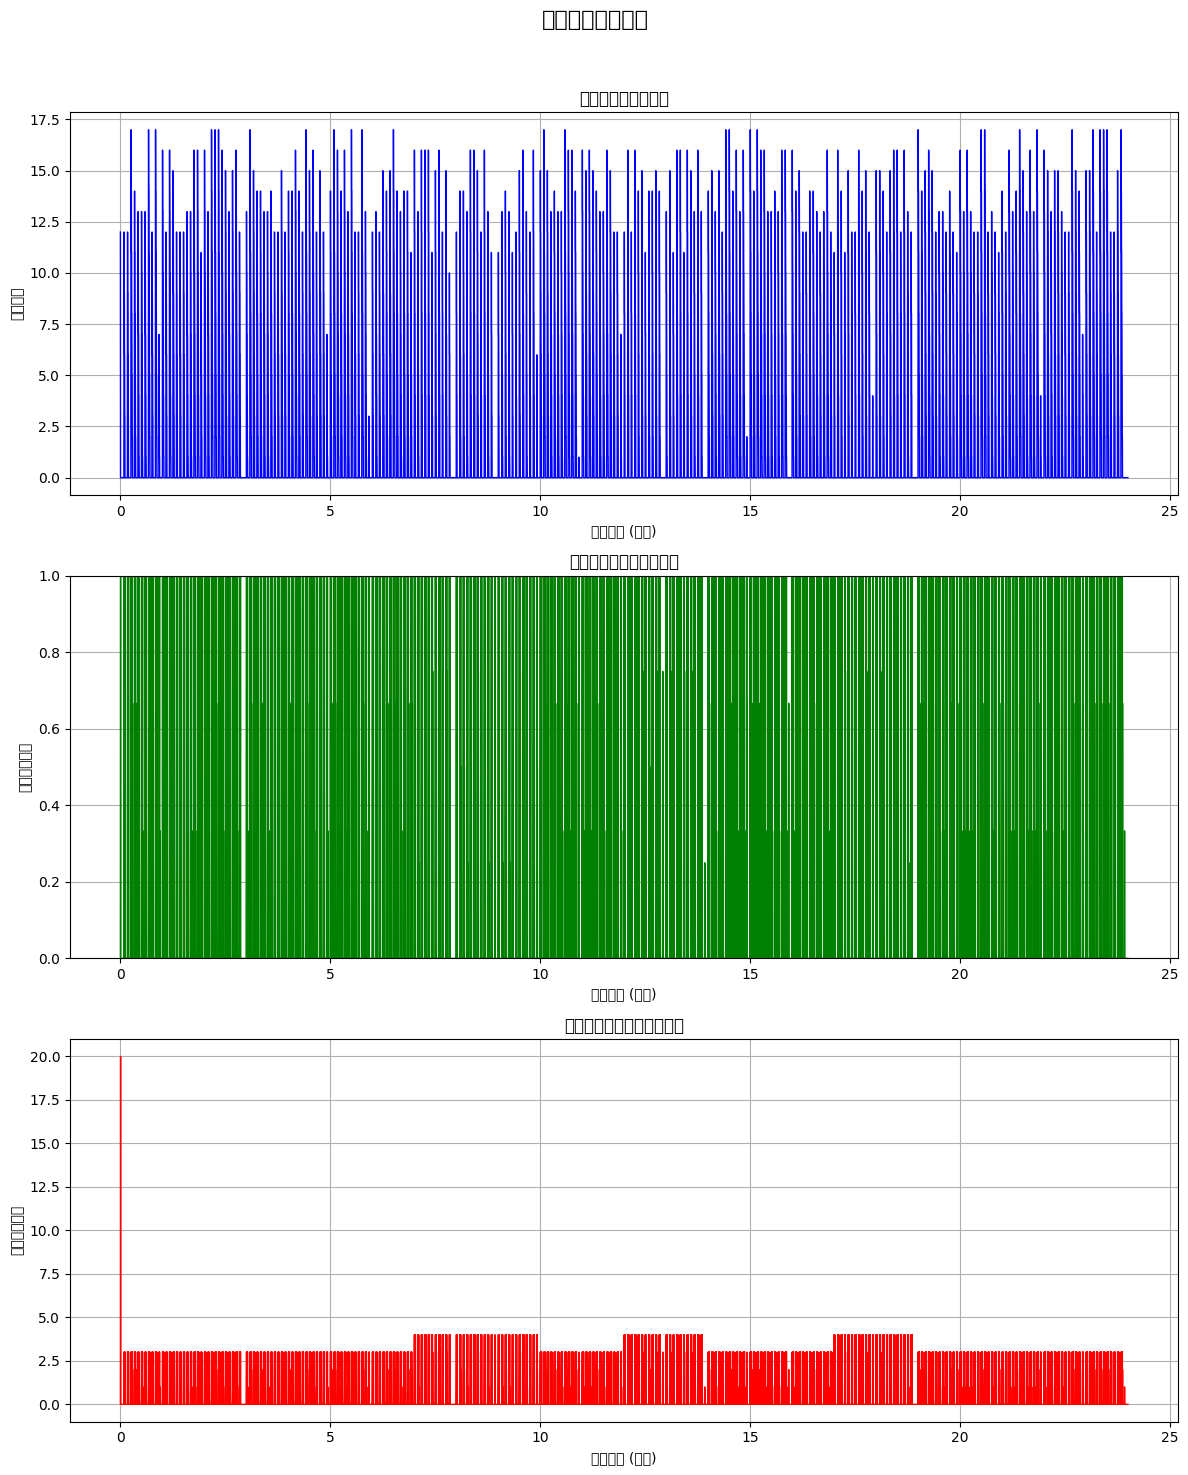

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21209 (\N{CJK UNIFIED IDEOGRAPH-52D9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas

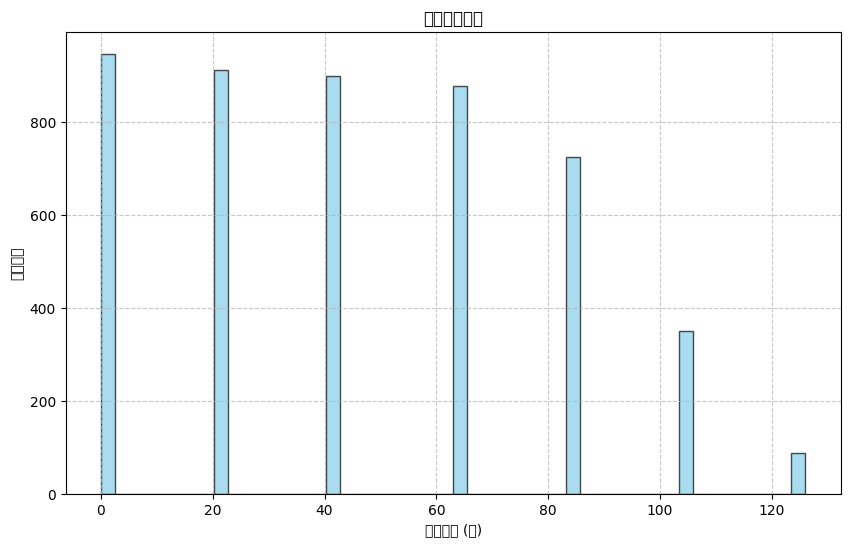

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


模擬器執行完成，結果已保存為 'optimized_system_results.pkl'
請在基本系統筆記本中也執行類似的模擬，將 is_optimized 設為 False
然後使用第三個筆記本進行比較分析


In [ ]:
# 在此處添加模擬器程式碼
# 這部分應該在原始系統程式碼之後

import time
import statistics
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import display

class SystemSimulator:
    def __init__(self, is_optimized=True, simulation_hours=24, random_seed=42):
        self.is_optimized = is_optimized
        self.simulation_hours = simulation_hours
        self.current_time = 0  # 模擬時間（秒）
        self.thread_status = {}
        self.job_queue = []
        self.completed_jobs = []
        self.thread_count = 8  # 初始/固定執行緒數
        self.total_jobs_in_hour = 0
        self.hour_start_time = 0
        self.job_arrival_history = []

        # 設置隨機種子確保結果可重複
        random.seed(random_seed)

        # 統計數據
        self.wait_times = []
        self.response_times = []
        self.thread_utilization = []
        self.queue_lengths = []
        self.active_threads = []
        self.time_records = []

        # 模擬不同負載的時段
        self.peak_hours = [7, 8, 9, 12, 13, 17, 18]  # 尖峰時段

        print(f"初始化{'優化' if is_optimized else '基本'}系統模擬器 (模擬時長: {simulation_hours}小時)")

    def get_thread_count(self):
        """計算當前應使用的執行緒數量"""
        if not self.is_optimized:
            return self.thread_count

        # 簡化的Little's Law實現
        # 計算最近一小時內的到達率
        recent_arrivals = [job for job, t in self.job_arrival_history
                           if t > self.current_time - 3600]

        if not recent_arrivals or self.current_time == 0:
            return self.thread_count

        arrival_rate = len(recent_arrivals) / max(1, min(3600, self.current_time))
        service_time = 20  # 固定服務時間

        # Little's Law: L = λW
        optimal_threads = max(3, min(20, int(arrival_rate * service_time)))

        # 考慮當前時段是否為尖峰時段
        current_hour = (self.current_time // 3600) % 24
        is_peak_hour = current_hour in self.peak_hours

        # 在尖峰時段增加執行緒數
        if is_peak_hour and self.is_optimized:
            optimal_threads = min(20, int(optimal_threads * 1.5))

        return optimal_threads

    def generate_jobs(self):
        """產生新任務"""
        # 檢查是否進入新的小時
        current_hour = self.current_time // 3600
        if current_hour > self.hour_start_time // 3600:
            self.total_jobs_in_hour = 0
            self.hour_start_time = current_hour * 3600

        # 確定產生任務數量
        if self.is_optimized:
            # 考慮當前佇列大小和系統負載
            queue_size = len(self.job_queue)
            running_jobs = sum(1 for job in self.thread_status.values()
                               if job["state"] == "RUNNING")

            # 計算系統負載因子
            current_thread_count = self.get_thread_count()
            load_factor = (running_jobs + queue_size) / max(1, current_thread_count)

            # 根據負載調整產生數量
            if load_factor > 1.2:  # 負載很高
                num_jobs = random.randint(1, 5)
            elif load_factor < 0.3:  # 負載很低
                num_jobs = random.randint(15, 20)
            else:  # 負載適中
                num_jobs = random.randint(5, 15)
        else:
            # 簡單版本：固定隨機數 (1-20)
            num_jobs = random.randint(1, 20)

        # 確保不超過每小時限制
        remaining_jobs = 200 - self.total_jobs_in_hour
        num_jobs = min(num_jobs, remaining_jobs)

        # 產生任務
        for _ in range(num_jobs):
            job_id = f"job_{len(self.thread_status)}"
            self.job_queue.append(job_id)
            self.thread_status[job_id] = {
                "state": "PENDING",
                "queue_time": self.current_time,
                "creation_time": self.current_time
            }
            self.job_arrival_history.append((job_id, self.current_time))

        self.total_jobs_in_hour += num_jobs
        return num_jobs

    def check_unfinished_tasks(self):
        """檢查未完成的任務並重新排程 (符合條件3)"""
        if self.current_time % 300 != 0:  # 每5分鐘檢查一次
            return

        rescheduled_count = 0

        for job_id in list(self.job_queue):
            if job_id in self.thread_status and self.thread_status[job_id]["state"] == "PENDING":
                # 計算等待時間
                wait_time = self.current_time - self.thread_status[job_id]["queue_time"]

                # 如果使用優化系統，長時間等待的任務會被提高優先級
                if self.is_optimized and wait_time > 300:  # 等待超過5分鐘
                    self.job_queue.remove(job_id)
                    self.job_queue.insert(0, job_id)  # 放到佇列前端
                    rescheduled_count += 1

        if rescheduled_count > 0 and self.is_optimized:
            print(f"[{self.format_time(self.current_time)}] 重新排程了 {rescheduled_count} 個長時間等待的任務")

    def process_jobs(self):
        """處理佇列中的任務"""
        current_thread_count = self.get_thread_count()
        running_jobs = sum(1 for job in self.thread_status.values()
                          if job["state"] == "RUNNING")

        # 記錄執行緒利用率
        self.thread_utilization.append(running_jobs / max(1, current_thread_count))
        self.active_threads.append(running_jobs)

        # 處理已完成的任務
        for job_id, status in list(self.thread_status.items()):
            if status["state"] == "RUNNING":
                if self.current_time >= status["start_time"] + 20:  # 任務完成 (20秒)
                    status["state"] = "COMPLETED"
                    status["completion_time"] = self.current_time

                    # 計算等待和響應時間
                    wait_time = status["start_time"] - status["queue_time"]
                    response_time = status["completion_time"] - status["queue_time"]

                    status["wait_time"] = wait_time
                    status["response_time"] = response_time

                    self.wait_times.append(wait_time)
                    self.response_times.append(response_time)
                    self.completed_jobs.append(job_id)

        # 檢查是否需要重新排程長等待任務
        self.check_unfinished_tasks()

        # 啟動新任務
        available_threads = current_thread_count - running_jobs
        for _ in range(min(available_threads, len(self.job_queue))):
            if not self.job_queue:
                break

            job_id = self.job_queue.pop(0)
            if job_id in self.thread_status and self.thread_status[job_id]["state"] == "PENDING":
                self.thread_status[job_id]["state"] = "RUNNING"
                self.thread_status[job_id]["start_time"] = self.current_time

    def format_time(self, seconds):
        """將秒數格式化為時:分:秒"""
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        secs = seconds % 60
        return f"{hours:02d}:{minutes:02d}:{secs:02d}"

    def run_simulation(self):
        """執行模擬"""
        total_simulation_time = self.simulation_hours * 3600  # 轉換為秒

        print(f"開始執行模擬 (總時長: {self.simulation_hours}小時)")
        simulation_start = time.time()  # 記錄實際執行時間

        progress_interval = total_simulation_time // 20  # 顯示20次進度
        next_progress = progress_interval

        while self.current_time < total_simulation_time:
            # 每5分鐘產生新任務
            if self.current_time % 300 == 0:
                self.generate_jobs()

            # 處理任務
            self.process_jobs()

            # 記錄佇列長度
            self.queue_lengths.append(len(self.job_queue))
            self.time_records.append(self.current_time)

            # 顯示進度
            if self.current_time >= next_progress:
                percent_done = (self.current_time / total_simulation_time) * 100
                print(f"模擬進度: {percent_done:.1f}% (模擬時間: {self.format_time(self.current_time)})")
                next_progress += progress_interval

            # 時間前進
            self.current_time += 1

        simulation_time = time.time() - simulation_start
        print(f"模擬完成 (實際執行時間: {simulation_time:.2f}秒)")

        # 返回模擬結果
        return self.get_statistics()

    def get_statistics(self):
        """取得模擬統計數據"""
        if not self.wait_times:
            return {
                "avg_wait_time": 0,
                "max_wait_time": 0,
                "avg_response_time": 0,
                "throughput": 0,
                "avg_queue_length": 0,
                "max_queue_length": 0,
                "thread_utilization": 0
            }

        # 等待時間分佈分析
        wait_times_np = np.array(self.wait_times)
        wait_time_dist = {
            "0-30秒": sum(1 for t in self.wait_times if t <= 30) / len(self.wait_times) * 100,
            "30-60秒": sum(1 for t in self.wait_times if 30 < t <= 60) / len(self.wait_times) * 100,
            "60-120秒": sum(1 for t in self.wait_times if 60 < t <= 120) / len(self.wait_times) * 100,
            "120-300秒": sum(1 for t in self.wait_times if 120 < t <= 300) / len(self.wait_times) * 100,
            "300+秒": sum(1 for t in self.wait_times if t > 300) / len(self.wait_times) * 100
        }

        stats = {
            "avg_wait_time": statistics.mean(self.wait_times),
            "max_wait_time": max(self.wait_times),
            "median_wait_time": statistics.median(self.wait_times),
            "p95_wait_time": np.percentile(self.wait_times, 95),
            "avg_response_time": statistics.mean(self.response_times),
            "throughput": len(self.completed_jobs) / (self.simulation_hours * 3600) * 3600,  # 每小時
            "avg_queue_length": statistics.mean(self.queue_lengths),
            "max_queue_length": max(self.queue_lengths),
            "thread_utilization": statistics.mean(self.thread_utilization),
            "wait_time_distribution": wait_time_dist,
            "completed_jobs": len(self.completed_jobs),
            "total_jobs": len(self.thread_status),
            "completion_rate": len(self.completed_jobs) / len(self.thread_status) * 100 if len(self.thread_status) > 0 else 0
        }

        return stats

    def plot_results(self):
        """繪製模擬結果圖表"""
        if not self.time_records:
            print("沒有模擬數據可用於繪圖")
            return None

        # 轉換時間記錄為小時
        hours = [t/3600 for t in self.time_records]

        # 建立子圖
        fig, axs = plt.subplots(3, 1, figsize=(12, 15))
        fig.suptitle(f"{'優化' if self.is_optimized else '基本'}系統模擬結果", fontsize=16)

        # 佇列長度隨時間變化
        axs[0].plot(hours, self.queue_lengths, 'b-', linewidth=1)
        axs[0].set_title('佇列長度隨時間變化')
        axs[0].set_xlabel('模擬時間 (小時)')
        axs[0].set_ylabel('佇列長度')
        axs[0].grid(True)

        # 執行緒利用率隨時間變化
        axs[1].plot(hours, self.thread_utilization, 'g-', linewidth=1)
        axs[1].set_title('執行緒利用率隨時間變化')
        axs[1].set_xlabel('模擬時間 (小時)')
        axs[1].set_ylabel('執行緒利用率')
        axs[1].set_ylim(0, 1.0)
        axs[1].grid(True)

        # 活躍執行緒數量隨時間變化
        axs[2].plot(hours, self.active_threads, 'r-', linewidth=1)
        axs[2].set_title('活躍執行緒數量隨時間變化')
        axs[2].set_xlabel('模擬時間 (小時)')
        axs[2].set_ylabel('活躍執行緒數')
        axs[2].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題

        # 等待時間分布直方圖
        plt.figure(figsize=(10, 6))
        plt.hist(self.wait_times, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title('等待時間分布')
        plt.xlabel('等待時間 (秒)')
        plt.ylabel('任務數量')
        plt.grid(True, linestyle='--', alpha=0.7)

        return fig

    def display_summary(self):
        """顯示模擬結果摘要"""
        stats = self.get_statistics()

        print("\n" + "="*50)
        print(f" {'優化' if self.is_optimized else '基本'}系統模擬結果摘要")
        print("="*50)

        print(f"\n效能指標:")
        print(f"平均等待時間: {stats['avg_wait_time']:.2f}秒")
        print(f"最大等待時間: {stats['max_wait_time']:.2f}秒")
        print(f"中位數等待時間: {stats['median_wait_time']:.2f}秒")
        print(f"95%分位等待時間: {stats['p95_wait_time']:.2f}秒")
        print(f"平均響應時間: {stats['avg_response_time']:.2f}秒")
        print(f"每小時任務處理量: {stats['throughput']:.2f}個/小時")
        print(f"平均佇列長度: {stats['avg_queue_length']:.2f}")
        print(f"最大佇列長度: {stats['max_queue_length']}")
        print(f"執行緒利用率: {stats['thread_utilization']*100:.2f}%")

        print(f"\n任務統計:")
        print(f"總任務數: {stats['total_jobs']}")
        print(f"完成任務數: {stats['completed_jobs']}")
        print(f"任務完成率: {stats['completion_rate']:.2f}%")

        print(f"\n等待時間分布:")
        for range_name, percentage in stats['wait_time_distribution'].items():
            print(f"{range_name}: {percentage:.2f}%")

        print("\n" + "="*50)

        return stats

# 創建並執行模擬器
def run_simulation(is_optimized=True, hours=24, seed=42):
    simulator = SystemSimulator(is_optimized=is_optimized, simulation_hours=hours, random_seed=seed)
    results = simulator.run_simulation()
    simulator.display_summary()

    # 繪製圖表
    simulator.plot_results()
    plt.show()

    return simulator, results

# 在優化系統筆記本執行
simulator, results = run_simulation(is_optimized=True)

# 保存結果供後續比較
import pickle
with open('optimized_system_results.pkl', 'wb') as f:
    pickle.dump({
        'stats': results,
        'wait_times': simulator.wait_times,
        'queue_lengths': simulator.queue_lengths,
        'thread_utilization': simulator.thread_utilization,
        'active_threads': simulator.active_threads,
        'time_records': simulator.time_records
    }, f)

# 下載結果檔案
from google.colab import files
files.download('optimized_system_results.pkl')

print("\n模擬器執行完成，結果已保存為 'optimized_system_results.pkl'")
print("請在基本系統筆記本中也執行類似的模擬，將 is_optimized 設為 False")
print("然後使用第三個筆記本進行比較分析")